In [1]:
# basemap environment 

import sys, string
from matplotlib import rc
import numpy as np
import pylab as pl
import netCDF4
import time as t
import datetime
from dateutil.parser import parse
from pylab import load, meshgrid, title, arange, show
from netcdftime import utime
import scipy.io
import matplotlib as mpl
import argparse
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import datetime as dt
from netCDF4 import num2date, date2num

In [2]:
tas_850_1850_mon_file = netCDF4.Dataset('tas_Amon_IPSL-CM5A-LR_past1000_r1i1p1_0850_1850_pacific.nc')
tas_850_1850_mon = tas_850_1850_mon_file.variables['tas'][:]

In [3]:
tas_850_1850_mon.shape

(12012, 48, 41)

In [4]:
# From https://link.springer.com/article/10.1007/s00382-003-0330-8
#  Time series of the first principal component of the detrended and low-pass filtered SST 
# in the Pacific Ocean domain (120°E–90°W; 45°S–45°N) 
tas_detrend = np.zeros((tas_850_1850_mon.shape))
tas_filt = np.zeros((tas_850_1850_mon.shape))

from scipy import signal

for i in range(tas_850_1850_mon.shape[1]):
    for j in range(tas_850_1850_mon.shape[2]):
        tas_detrend[:,i,j] = signal.detrend(tas_850_1850_mon[:,i,j])


In [5]:
def iirfilter(x, N=4, pass_freq=0.7 / 12.):
    """
    Returns the forward-backward filtered signal using a Butterworth filter.
    """
    b, a = signal.butter(N, pass_freq, "low", analog=False)
    return  signal.filtfilt(b, a, x)

for i in range(tas_850_1850_mon.shape[1]):
    for j in range(tas_850_1850_mon.shape[2]):
        tas_filt[:,i,j] = iirfilter(tas_detrend[:,i,j], N=5, pass_freq=0.97 / 96)


/iitm2/cccr-res/msingh/anaconda3/envs/basemap1/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [6]:
import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof

In [7]:
lat  = tas_850_1850_mon_file.variables['lat'][:]
lon  = tas_850_1850_mon_file.variables['lon'][:]
tas_850_1850_mon_file.close()

In [8]:
# EOF and PCA from https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex17-EOF%20analysis%20global%20hgt500.ipynb
# Create an EOF solver to do the EOF analysis
wgts   = np.cos(np.deg2rad(lat))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(tas_filt, weights=wgts)

In [9]:
# Retrieve the leading EOFs
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

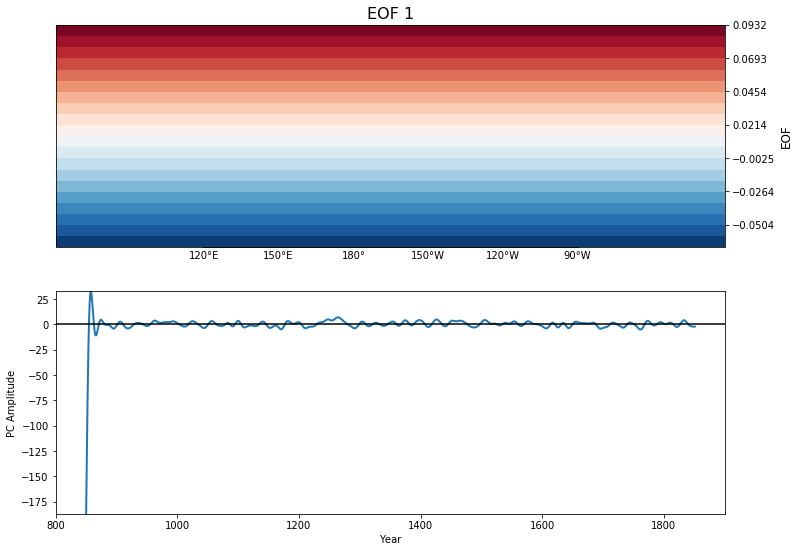

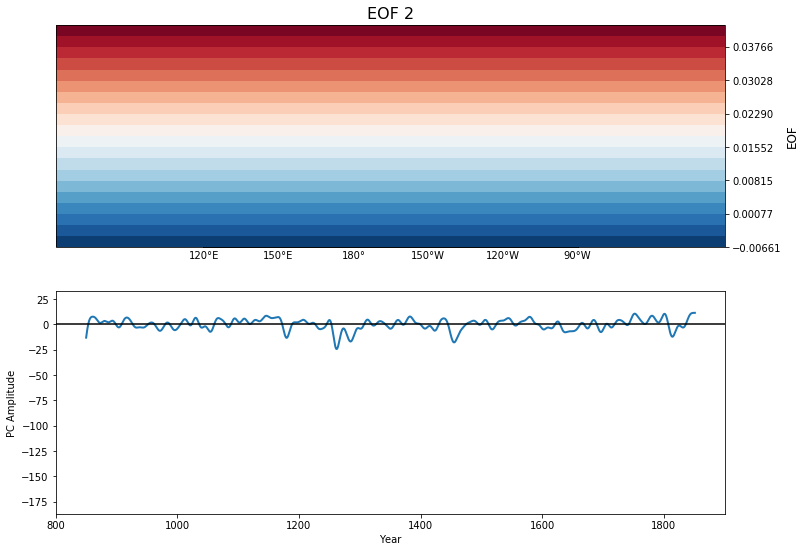

In [16]:
#Visualize leading EOFs
nt,nlat,nlon = tas_filt.shape   
parallels = np.arange(-90,90,30.)
meridians = np.arange(-180,180,30)

for i in range(0,2):
    fig = plt.figure(figsize=(12,9))
    plt.subplot(211)
    
    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat), urcrnrlon=max(lon), urcrnrlat=max(lat))    
    x, y = m(*np.meshgrid(lon, lat))
    clevs = np.linspace(np.min(eof1[i,:,:].squeeze()), np.max(eof1[i,:,:].squeeze()), 21)
    cs = m.contourf(x, y, eof1[i,:,:].squeeze(), clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()  
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])

    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    days = np.linspace(850,1851,nt)
    plt.plot(days, pc1[:,i], linewidth=2)
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')   
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))

(9.278544132184348e-33, 0.4841516955614366)

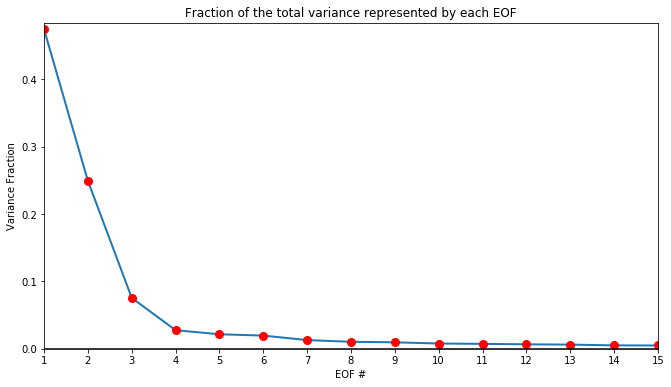

In [13]:
# Check variances explained by leading EOFs
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

In [15]:
pc1[:,1].shape

(12012,)

In [25]:
# Checking if a point is land or ocean https://gis.stackexchange.com/questions/235133/checking-if-a-geocoordinate-point-is-land-or-ocean
# first argument is lon and second lat confirmed from https://stackoverflow.com/questions/43299279/is-land-in-basemap-python
bm = Basemap() 
if(bm.is_land(99.675, 13.104)==True):
    print("test")

test


In [20]:
lat.shape

(48,)

In [21]:
lon.shape

(41,)

In [22]:
tas_filt.shape

(12012, 48, 41)

In [29]:
# masking out land points 
tas_filt_ocean = np.zeros((tas_filt.shape))
for i in range(lon.shape[0]):
    for j in range(lat.shape[0]):
        if(bm.is_land(lon[i], lat[j])==False):
            tas_filt_ocean[:,j,i] = tas_filt[:,j,i]

In [30]:
# Doing an EOF/PCA analysis of this ocean tas data 
# EOF and PCA from https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex17-EOF%20analysis%20global%20hgt500.ipynb
# Create an EOF solver to do the EOF analysis
wgts   = np.cos(np.deg2rad(lat))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(tas_filt_ocean, weights=wgts)

In [31]:
# Retrieve the leading EOFs
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

In [32]:
# Retrieve the leading EOFs
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

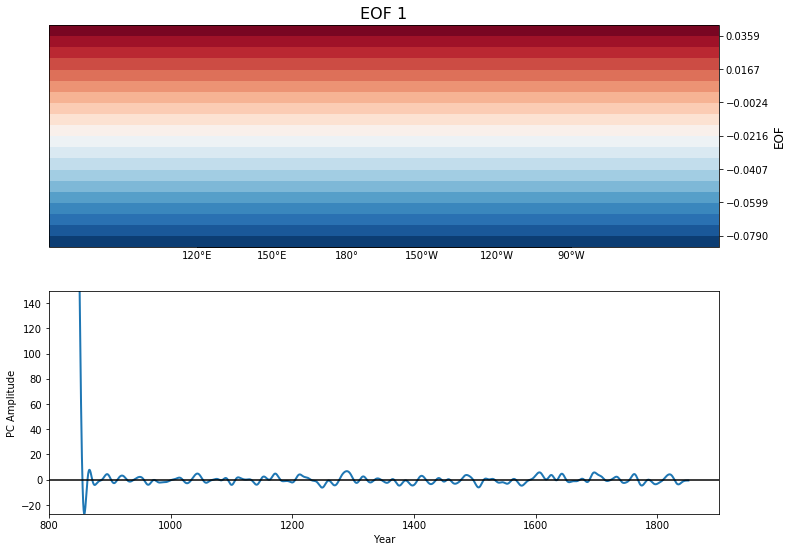

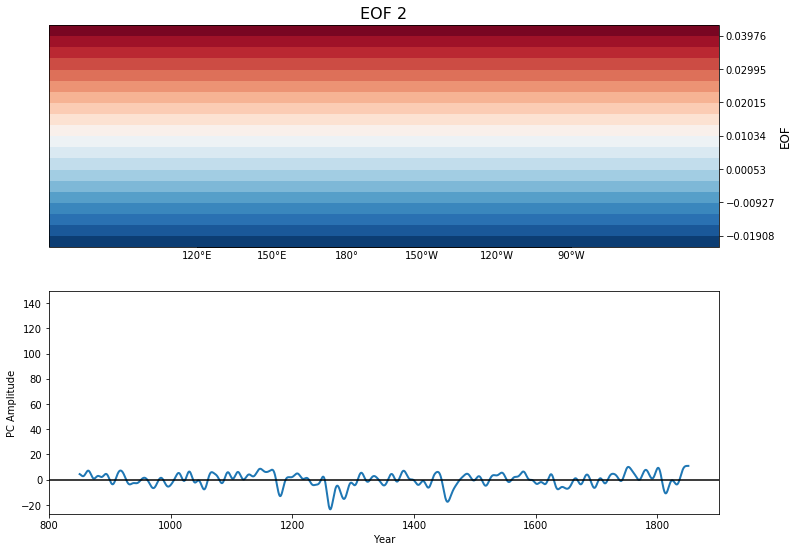

In [35]:
#Visualize leading EOFs
nt,nlat,nlon = tas_filt.shape   
parallels = np.arange(-90,90,30.)
meridians = np.arange(-180,180,30)

for i in range(0,2):
    fig = plt.figure(figsize=(12,9))
    plt.subplot(211)
    
    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat), urcrnrlon=max(lon), urcrnrlat=max(lat))    
    x, y = m(*np.meshgrid(lon, lat))
    clevs = np.linspace(np.min(eof1[i,:,:].squeeze()), np.max(eof1[i,:,:].squeeze()), 21)
    cs = m.contourf(x, y, eof1[i,:,:].squeeze(), clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()  
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])

    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    days = np.linspace(850,1851,nt)
    plt.plot(days, pc1[:,i], linewidth=2)
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')   
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))

In [34]:
lon

masked_array(data=[120.  , 123.75, 127.5 , 131.25, 135.  , 138.75, 142.5 ,
                   146.25, 150.  , 153.75, 157.5 , 161.25, 165.  , 168.75,
                   172.5 , 176.25, 180.  , 183.75, 187.5 , 191.25, 195.  ,
                   198.75, 202.5 , 206.25, 210.  , 213.75, 217.5 , 221.25,
                   225.  , 228.75, 232.5 , 236.25, 240.  , 243.75, 247.5 ,
                   251.25, 255.  , 258.75, 262.5 , 266.25, 270.  ],
             mask=False,
       fill_value=1e+20)

In [37]:
pc1[:,1].shape

(12012,)

In [44]:
mon = np.arange(850,1851,1/12)

In [45]:
mon.shape

(12012,)

In [47]:
import seaborn as sns
sns.set()
plt.plot(mon,pc1[:,1])

ImportError: No module named 'seaborn'